In [1]:
import warnings
warnings.filterwarnings("ignore")

import cupy as cp
from cupyx.scipy.special import erfinv
import cudf as gd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import erfinv as sp_erfinv

### GaussRank transformation

In [2]:
x_gpu = cp.random.rand(20) # input array
x_cpu = cp.asnumpy(x_gpu)

r_gpu = x_gpu.argsort().argsort() # compute the rank
r_cpu = x_cpu.argsort().argsort() 

r_gpu = (r_gpu/r_gpu.max()-0.5)*2 # scale to (-1,1)
epsilon = 1e-6
r_gpu = cp.clip(r_gpu,-1+epsilon,1-epsilon)

r_cpu = (r_cpu/r_cpu.max()-0.5)*2 # scale to (-1,1)
r_cpu = cp.clip(r_cpu,-1+epsilon,1-epsilon)

r_gpu = erfinv(r_gpu) # map to gaussian
r_cpu = sp_erfinv(r_cpu) # map to gaussian

### Inverse transformation step by step

In [3]:
df_cpu = pd.DataFrame({'src':x_cpu,'tgt':r_cpu}) 
df_gpu = gd.DataFrame({'src':x_gpu,'tgt':r_gpu}) # pass cupy array to cudf dataframe

df_cpu = df_cpu.sort_values('src') # sort
df_gpu = df_gpu.sort_values('src')

pos_cpu = df_cpu['tgt'].searchsorted(r_cpu, side='left') # search
pos_gpu = df_gpu['tgt'].searchsorted(r_gpu, side='left')

In [4]:
def linear_inter_polate(df,x,pos):
    N = df.shape[0]
    pos[pos>=N] = N-1
    pos[pos-1<=0] = 0
    if isinstance(x,cp.ndarray):
        pos = pos.values
        
    x1 = df['tgt'].values[pos]
    x2 = df['tgt'].values[pos-1]
    y1 = df['src'].values[pos]
    y2 = df['src'].values[pos-1]

    relative = (x-x2)  / (x1-x2)
    return (1-relative)*y2 + relative*y1

In [5]:
x_inv_cpu = linear_inter_polate(df_cpu,r_cpu,pos_cpu) # linear inter polate
x_inv_gpu = linear_inter_polate(df_gpu,r_gpu,pos_gpu)

GaussRank CPU


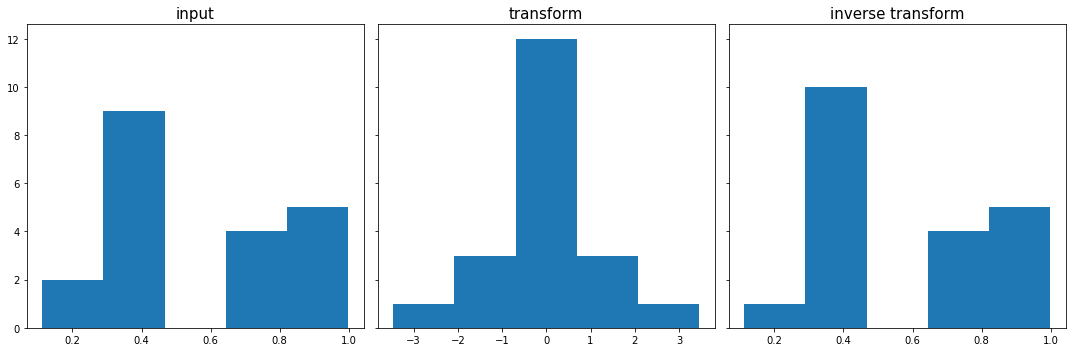

In [6]:
n_bins = 5
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
fig.set_figheight(5)
fig.set_figwidth(15)
axs[0].hist(x_cpu, bins=n_bins)
axs[0].set_title('input',fontsize=15)
axs[1].hist(r_cpu, bins=n_bins)
axs[1].set_title('transform',fontsize=15)
_ = axs[2].hist(x_inv_cpu, bins=n_bins)
axs[2].set_title('inverse transform',fontsize=15)
print('GaussRank CPU')

GaussRank GPU


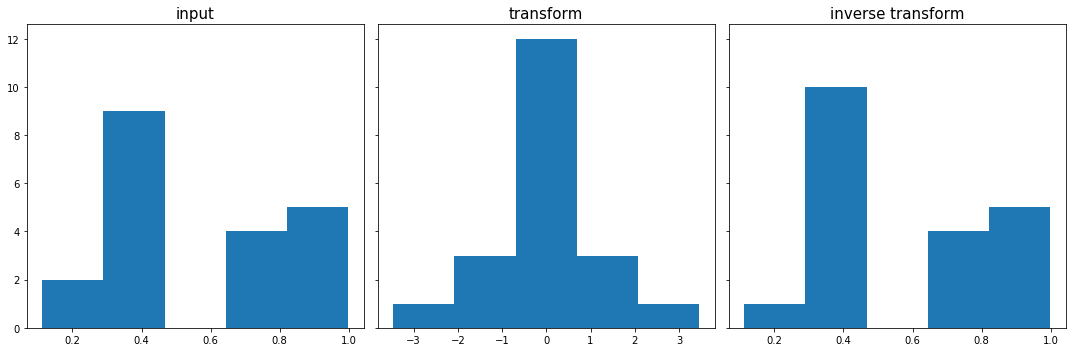

In [7]:
n_bins = 5
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
fig.set_figheight(5)
fig.set_figwidth(15)
axs[0].hist(cp.asnumpy(x_gpu), bins=n_bins)
axs[0].set_title('input',fontsize=15)
axs[1].hist(cp.asnumpy(r_gpu), bins=n_bins)
axs[1].set_title('transform',fontsize=15)
_ = axs[2].hist(cp.asnumpy(x_inv_gpu), bins=n_bins)
axs[2].set_title('inverse transform',fontsize=15)
print('GaussRank GPU')